<a href="https://colab.research.google.com/github/tatha04/Spin_Clusters/blob/main/Spin_Clusters2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def dec2dual(M,N):
  "Converts an integer M into a bitstring of length N"
  binary_string = bin(M)[2:].zfill(N)
  return [int(binary_string[N-1-i]) for i in range(N)]

In [61]:
class Spin_Cluster:
  """A class contains functions of a finite spin system
    N = Number of spins
    L = Number of links
    Site1,2: Sites corresponding to links
    J = Spin-exchange interactions
    alpha = x,y,z component of Ising-interactions"
  """
  
  def __init__(self,N,L,Site1,Site2,alpha,J):
    """ N = Number of spins
        L = Number of links (spin interactions)
        Site1,2 = List of spin sites corresponding to links
        alpha = List containing x,y,z component of Ising-interactions 
        ** To be edited. add another option to alpha for Heisenberg interactions"""

    self.N = N
    self.L = L
    self.site1 = Site1
    self.site2 = Site2
    self.alpha = alpha
    self.J = J
    
    # Define the necessary matrices 
    self.H0 = np.zeros((2**N,2**N))   # Hamiltonian
    self.V  = np.zeros((2**N,2**N))   # Eigenvectors
    self.E  = np.zeros(2**N)          # Eigenvalues
    self.E_Deg = None                 # Degenerate Eigenvalues
    self.N_Deg = None                 # Degeneracies
    self.E_Deg_count = None           # No. of Degenerate Eigenvalues
    self.temperatures = None          # Temperatures
    self.E_exp = None                 # Energy Expectation
    self.S = None                     # Entropy
    self.Cv = None                    # Specific Heat

        
  def Hamiltonian(self):
    """ Set up the Hamiltonian of the spin cluster. """
    for i in range(2**self.N):
      z = dec2dual(i,self.N)
      for j in range(self.L):
        p = self.site1[j]
        q = self.site2[j]
        i_prime = i + (1-2*z[p-1])*2**(p-1) + (1-2*z[q-1])*2**(q-1)
        if (self.alpha[j] == 1):
          self.H0[i_prime,i] += self.J[j]
        elif (self.alpha[j] == 2):
          self.H0[i_prime,i] -= self.J[j]*(2*z[p-1]-1)*(2*z[q-1]-1)
        elif (self.alpha[j] == 3):
          self.H0[i,i] += self.J[j]*(2*z[p-1]-1)*(2*z[q-1]-1)

  def Eigen(self):
    """ Find out the eigenvalues and eigenvalues of the Hamiltonian Matrix. """
    self.E, self.V = np.linalg.eigh(self.H0)
    self.E_degeneracy()

  def E_degeneracy(self,acc = 1e-12):
    """ Find out the degenerate energy levels along with the degeneracy of the spectrum
        acc (optional): If energy levels are within acc, then consider them to be degenerate. """
    M_val = [0.0]; M_deg = [0]
    M_val[0] = self.E[0]; M_deg[0] = 1; count = 0;
    for i in range(1,2**self.N):
       if (abs(self.E[i] - M_val[count]) < acc):
          M_deg[count] += 1
       else:
          count += 1
          M_val.append(self.E[i])
          M_deg.append(1)
    self.E_Deg = M_val; self.N_Deg = M_deg; self.E_Deg_count = count+1

  def plot_Energy(self):
    """ Plot the frequency of the degenerate energy levels. """
    fig = plt.figure()
    #title_string = string("Jx=",string(Jx),", Jy=",string(Jy),", Jz=",string(Jz));
    title_string = 'Energy Spectrum'
    plt.title(title_string);
    plt.xlabel('Energy')
    plt.ylabel('# of Degeneracies')
    plt.bar(self.E_Deg,self.N_Deg)
    plt.savefig('Energy.png')

  def print_Energy(self):
    print('Degeneracy  Energy')
    [print(f' {self.N_Deg[i]:5d}  {self.E_Deg[i]:10.4f}') for i in range(self.E_Deg_count)]
    print(f'Total No. of Degenerate Energy Levels = {self.E_Deg_count:5d}')

  def Thermodynamics(self,thi = 10.0, tlo = 0.01 ,ntemp = 100):
    """ Calculate the following thermodynamical quantities as a function of temperature.
        <Energy>, Entropy and Specific heat.
        thi/tlo = highest/lowest temperature.
        ntemp = No. of temperatures (on a logarithmic scale) at which the qnts. are measured.
          """
    
    #temperatures = np.logspace(thi,tlo,num=ntemp);
    temperatures = np.logspace(np.log10(thi),np.log10(tlo),num = ntemp)
    self.E_exp = np.zeros(ntemp);
    self.S     = np.zeros(ntemp);
    self.Cv    = np.zeros(ntemp);

    i = 0
    for temp in temperatures:
      beta = 1/temp
      z = sum(np.exp(-beta*self.E))                             # Partition function
      e = sum(np.multiply(self.E,np.exp(-beta*self.E)))/z       # <E>
      e2 = sum(np.multiply(np.multiply(self.E,self.E),np.exp(-beta*self.E)))/z # <E^2>
      cv = beta**2 * (e2 - e**2)
      entropy = beta*e + np.log(z)
      self.E_exp[i] = e; self.Cv[i] = cv; self.S[i] = entropy;
      i = i+1

    # Plot thermodynamical quantities
    fig = plt.figure(figsize=(18,6))
    plt.suptitle('Thermodynmics')

    plt.subplot(1,3,1)
    plt.xlabel('Temperature (T)')
    plt.ylabel(r'$\langle E \rangle$')
    plt.xscale("log")
    plt.plot(temperatures,self.E_exp)

    plt.subplot(1,3,2)
    plt.xlabel('Temperature (T)')
    plt.ylabel('Entropy (S)')
    plt.xscale("log")
    plt.plot(temperatures,self.S)

    plt.subplot(1,3,3)
    plt.xlabel('Temperature (T)')
    plt.ylabel('Specific Heat (Cv)')
    plt.xscale("log")
    plt.plot(temperatures,self.Cv)

    plt.savefig('Thermodynamics.png')

  def Plaquette_Flux(self):
    """ Define the plaquette flux operators in the original basis.
    Calculate the expectation value of the flux operators in the ground state."""


In [62]:
class Kitaev_cube:
  """ Class containing sites and links for a Kitaev-cubic-cluster 
  consisting of N = 8 sites and L = 12 links. """

  def __init__( self, K, Kp = None ):
    """ K = Kitaev Couplings between the sites
        Kp (optional) = K' Kitaev couplings between site 1 and the nearest neighbor sites"""

    self.N = 8
    self.L = 12
    self.Site1 = [1,2,3,4,5,6,7,8,1,2,3,4]
    self.Site2 = [2,3,4,1,6,7,8,5,5,6,7,8]
    self.alpha = [1,2,1,2,1,2,1,2,3,3,3,3]
    #self.J     = [1,1,1,1,1,1,1,1,1,1,1,1]
    self.J     = [K]*self.L

    #if (Kp != None):
      # Assign corner interactions to Kp

    self.Spin_Cluster = Spin_Cluster(self.N,self.L,self.Site1,self.Site2,self.alpha,self.J)

  def plot_cluster(self):
    """ Plots the N = 8 spin cluster """
    
    # Co-ordinates for cluster
    cluster_x = [-1,1,1,-1,-2,2,2,-2]
    cluster_y = [1,1,-1,-1,2,2,-2,-2]
    fig = plt.figure()
    plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    link_color = ["red","green","blue"]
    plt.scatter(cluster_x,cluster_y)
    for i in range(self.L):
        x = [cluster_x[self.Site1[i]-1],cluster_x[self.Site2[i]-1]]
        y = [cluster_y[self.Site1[i]-1],cluster_y[self.Site2[i]-1]]
        plt.plot(x, y, color = link_color[self.alpha[i]-1])

    plt.title("Kitaev-cube with x(red), y(green) and z(blue) interactions ")
    plt.savefig('Cluster.png')

Degeneracy  Energy
     1     -6.9282
     3     -6.4721
    12     -5.8064
     3     -5.6569
    12     -5.4641
     6     -4.0000
    12     -3.4186
    24     -2.8284
     3     -2.4721
    12     -1.6121
    12     -1.4641
    56     -0.0000
    12      1.4641
    12      1.6121
     3      2.4721
    24      2.8284
    12      3.4186
     6      4.0000
    12      5.4641
     3      5.6569
    12      5.8064
     3      6.4721
     1      6.9282
Total No. of Degenerate Energy Levels =    23


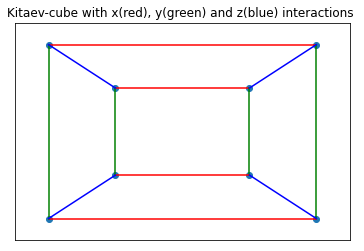

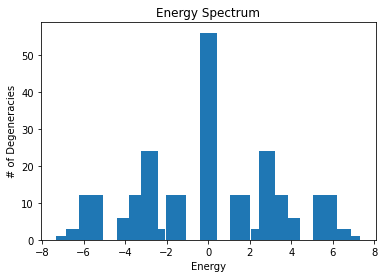

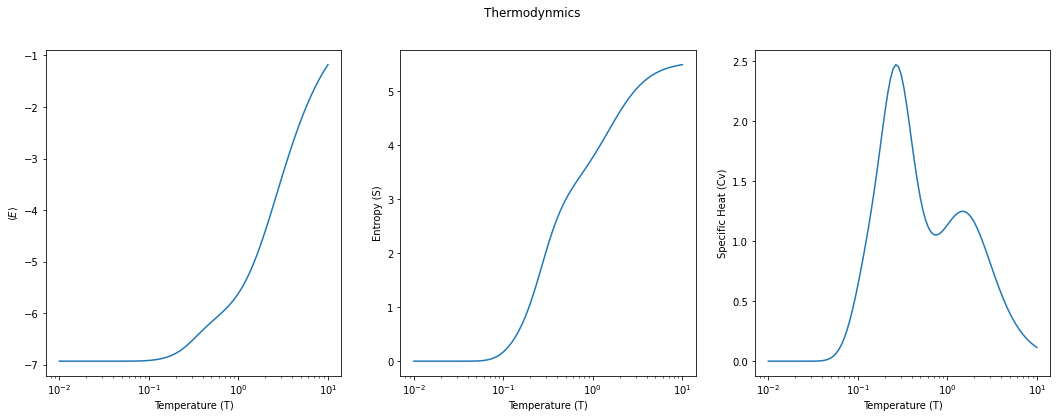

In [63]:
cube = Kitaev_cube(1.0)
cube.Spin_Cluster.Hamiltonian()
cube.Spin_Cluster.Eigen()
cube.plot_cluster()
cube.Spin_Cluster.plot_Energy()
cube.Spin_Cluster.print_Energy()
cube.Spin_Cluster.Thermodynamics()